# Dependent density regression
In another [example](dp_mix.ipynb), we showed how to use Dirichlet processes to perform Bayesian nonparametric density estimation.  This example expands on the previous one, illustrating dependent density regression.

Just as Dirichlet process mixtures can be thought of as infinite mixture models that select the number of active components as part of inference, dependent density regression can be thought of as infinite [mixtures of experts](https://en.wikipedia.org/wiki/Committee_machine) that select the active experts as part of inference.  Their flexibility and modularity make them powerful tools for performing nonparametric Bayesian Data analysis.

In [2]:
import aesara.tensor as at
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from IPython.display import HTML
from matplotlib import animation as ani
from matplotlib import pyplot as plt

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v3.11.2


In [3]:
%config InlineBackend.figure_format = 'retina'
plt.rc("animation", writer="ffmpeg")
blue, *_ = sns.color_palette()
az.style.use("arviz-darkgrid")
SEED = 972915  # from random.org; for reproducibility
np.random.seed(SEED)

We will use the LIDAR data set from Larry Wasserman's excellent book, [_All of Nonparametric Statistics_](http://www.stat.cmu.edu/~larry/all-of-nonpar/).  We standardize the data set to improve the rate of convergence of our samples.

In [4]:
DATA_URI = "http://www.stat.cmu.edu/~larry/all-of-nonpar/=data/lidar.dat"


def standardize(x):
    return (x - x.mean()) / x.std()


df = pd.read_csv(DATA_URI, sep=r"\s{1,3}", engine="python").assign(
    std_range=lambda df: standardize(df.range), std_logratio=lambda df: standardize(df.logratio)
)

In [5]:
df.head()

,range,logratio,std_range,std_logratio
0,390,-0.050356,-1.717725,0.852467
1,391,-0.060097,-1.707299,0.817981
2,393,-0.041901,-1.686447,0.882398
3,394,-0.050985,-1.676020,0.850240
4,396,-0.059913,-1.655168,0.818631


We plot the LIDAR data below.

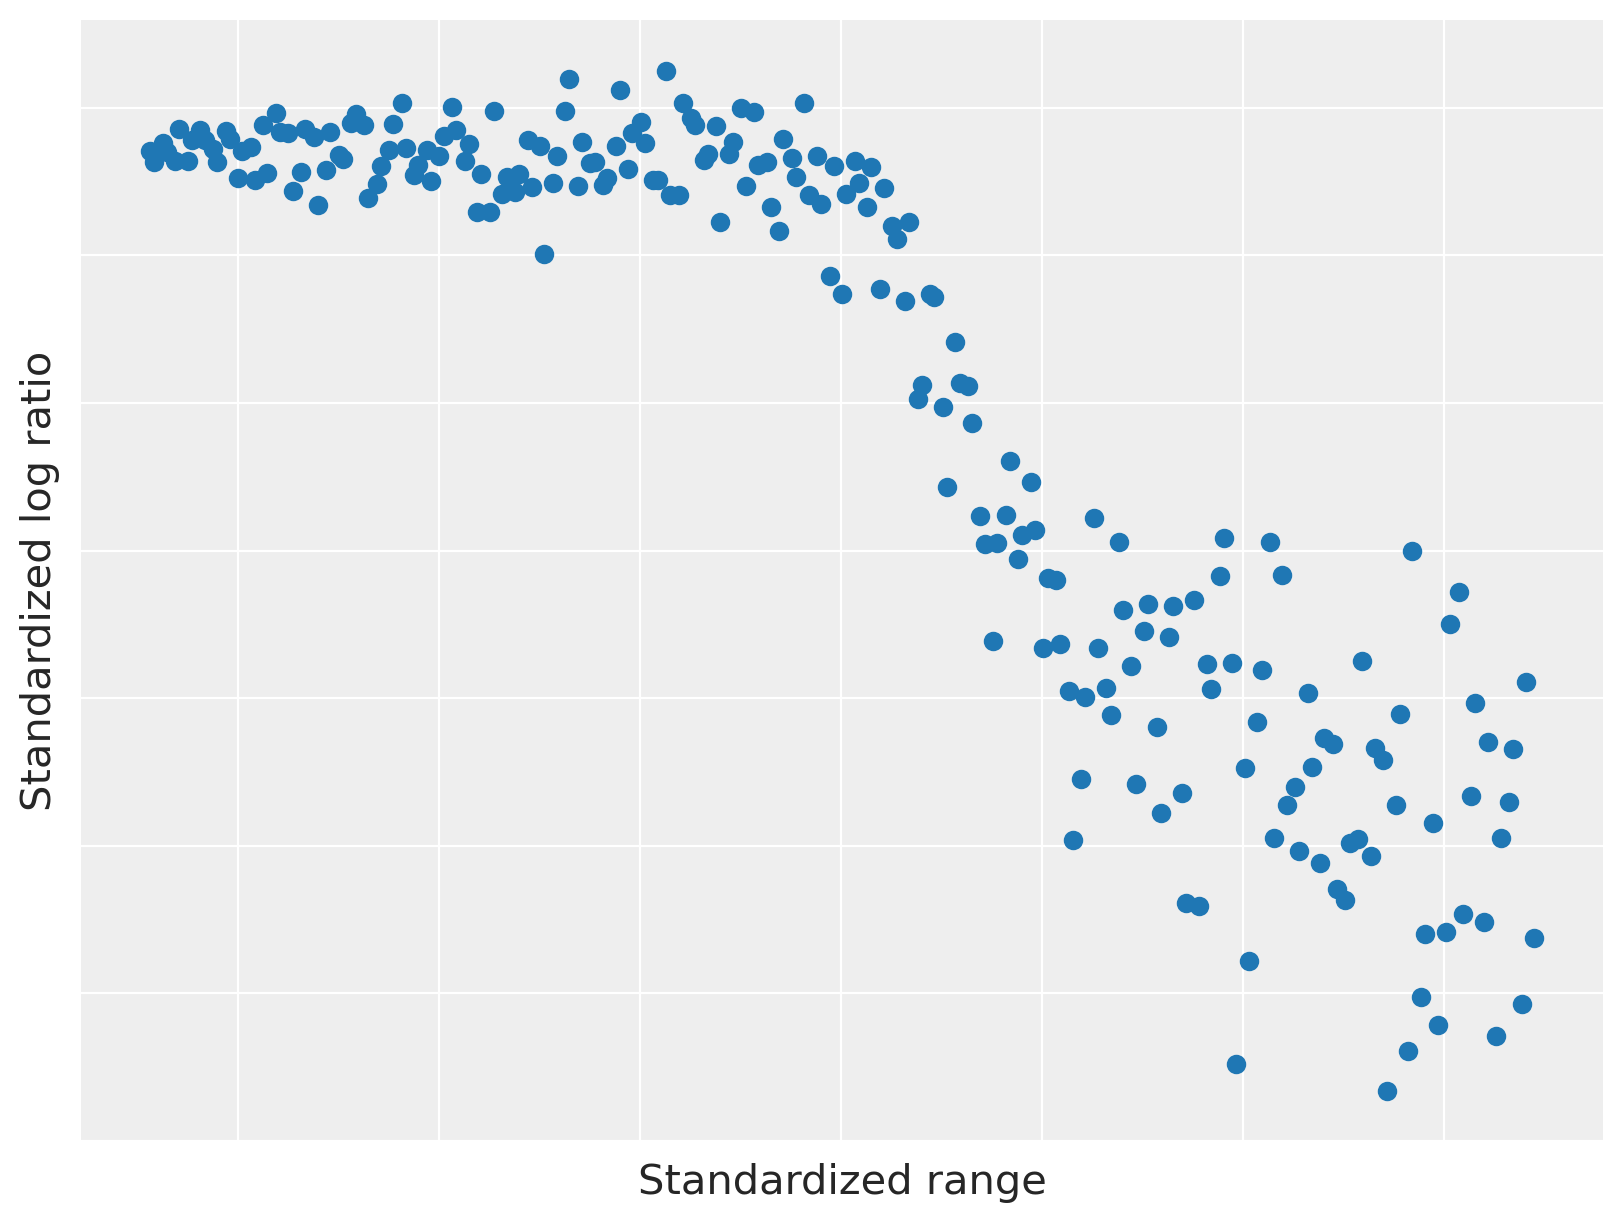

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df.std_range, df.std_logratio, color=blue)

ax.set_xticklabels([])
ax.set_xlabel("Standardized range")

ax.set_yticklabels([])
ax.set_ylabel("Standardized log ratio");

This data set has a two interesting properties that make it useful for illustrating dependent density regression.

1. The relationship between range and log ratio is nonlinear, but has locally linear components.
2. The observation noise is [heteroskedastic](https://en.wikipedia.org/wiki/Heteroscedasticity); that is, the magnitude of the variance varies with the range.

The intuitive idea behind dependent density regression is to reduce the problem to many (related) density estimates, conditioned on fixed values of the predictors.  The following animation illustrates this intuition.

In [7]:
fig, (scatter_ax, hist_ax) = plt.subplots(ncols=2, figsize=(16, 6))

scatter_ax.scatter(df.std_range, df.std_logratio, color=blue, zorder=2)

scatter_ax.set_xticklabels([])
scatter_ax.set_xlabel("Standardized range")

scatter_ax.set_yticklabels([])
scatter_ax.set_ylabel("Standardized log ratio")

bins = np.linspace(df.std_range.min(), df.std_range.max(), 25)

hist_ax.hist(df.std_logratio, bins=bins, color="k", lw=0, alpha=0.25, label="All data")

hist_ax.set_xticklabels([])
hist_ax.set_xlabel("Standardized log ratio")

hist_ax.set_yticklabels([])
hist_ax.set_ylabel("Frequency")

hist_ax.legend(loc=2)

endpoints = np.linspace(1.05 * df.std_range.min(), 1.05 * df.std_range.max(), 15)

frame_artists = []

for low, high in zip(endpoints[:-1], endpoints[2:]):
    interval = scatter_ax.axvspan(low, high, color="k", alpha=0.5, lw=0, zorder=1)
    *_, bars = hist_ax.hist(
        df[df.std_range.between(low, high)].std_logratio, bins=bins, color="k", lw=0, alpha=0.5
    )

    frame_artists.append((interval,) + tuple(bars))

animation = ani.ArtistAnimation(fig, frame_artists, interval=500, repeat_delay=3000, blit=True)
plt.close()
# prevent the intermediate figure from showing

In [8]:
HTML(animation.to_html5_video())

As we slice the data with a window sliding along the x-axis in the left plot, the empirical distribution of the y-values of the points in the window varies in the right plot.  An important aspect of this approach is that the density estimates that correspond to close values of the predictor are similar.

In the previous example, we saw that a Dirichlet process estimates a probability density as a mixture model with infinitely many components.  In the case of normal component distributions,

$$y \sim \sum_{i = 1}^{\infty} w_i \cdot N(\mu_i, \tau_i^{-1}),$$

where the mixture weights, $w_1, w_2, \ldots$, are generated by a [stick-breaking process](https://en.wikipedia.org/wiki/Dirichlet_process#The_stick-breaking_process).

Dependent density regression generalizes this representation of the Dirichlet process mixture model by allowing the mixture weights and component means to vary conditioned on the value of the predictor, $x$.  That is,

$$y\ |\ x \sim \sum_{i = 1}^{\infty} w_i\ |\ x \cdot N(\mu_i\ |\ x, \tau_i^{-1}).$$

In this example, we will follow Chapter 23 of [_Bayesian Data Analysis_](http://www.stat.columbia.edu/~gelman/book/) and use a probit stick-breaking process to determine the conditional mixture weights, $w_i\ |\ x$.  The probit stick-breaking process starts by defining

$$v_i\ |\ x = \Phi(\alpha_i + \beta_i x),$$

where $\Phi$ is the cumulative distribution function of the standard normal distribution.  We then obtain $w_i\ |\ x$ by applying the stick breaking process to $v_i\ |\ x$.  That is,

$$w_i\ |\ x = v_i\ |\ x \cdot \prod_{j = 1}^{i - 1} (1 - v_j\ |\ x).$$

For the LIDAR data set, we use independent normal priors $\alpha_i \sim N(0, 5^2)$ and $\beta_i \sim N(0, 5^2)$.  We now express this this model for the conditional mixture weights using `PyMC`.

In [9]:
def norm_cdf(z):
    return 0.5 * (1 + at.erf(z / np.sqrt(2)))


def stick_breaking(v):
    return v * at.concatenate(
        [at.ones_like(v[:, :1]), at.extra_ops.cumprod(1 - v, axis=1)[:, :-1]], axis=1
    )

In [10]:
N = len(df)
K = 20

std_range = df.std_range.values[:, np.newaxis]
std_logratio = df.std_logratio.values

with pm.Model(coords={"N": np.arange(N), "K": np.arange(K) + 1, "one": [1]}) as model:
    alpha = pm.Normal("alpha", 0.0, 5.0, dims="K")
    beta = pm.Normal("beta", 0.0, 5.0, dims=("one", "K"))
    x = pm.Data("x", std_range)
    v = norm_cdf(alpha + pm.math.dot(x, beta))
    w = pm.Deterministic("w", stick_breaking(v), dims=["N", "K"])

We have defined `x` as a `pm.Data` container in order to use `PyMC`'s posterior prediction capabilities later.

While the dependent density regression model theoretically has infinitely many components, we must truncate the model to finitely many components (in this case, twenty) in order to express it using `PyMC`.  After sampling from the model, we will verify that truncation did not unduly influence our results.

Since the LIDAR data seems to have several linear components, we use the linear models

$$
\begin{align*}
\mu_i\ |\ x
    & \sim \gamma_i + \delta_i x \\
\gamma_i
    & \sim N(0, 10^2) \\
\delta_i
    & \sim N(0, 10^2)
\end{align*}
$$

for the conditional component means.

In [11]:
with model:
    gamma = pm.Normal("gamma", 0.0, 10.0, dims="K")
    delta = pm.Normal("delta", 0.0, 10.0, dims=("one", "K"))
    mu = pm.Deterministic("mu", gamma + pm.math.dot(x, delta))

Finally, we place the prior $\tau_i \sim \textrm{Gamma}(1, 1)$ on the component precisions.

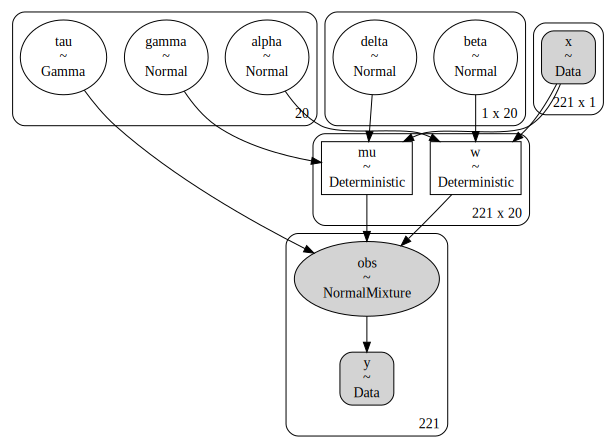

In [12]:
with model:
    tau = pm.Gamma("tau", 1.0, 1.0, dims="K")
    y = pm.Data("y", std_logratio)
    obs = pm.NormalMixture("obs", w, mu, tau=tau, observed=y)

pm.model_to_graphviz(model)

We now sample from the dependent density regression model.

In [13]:
SAMPLES = 20000
BURN = 10000

with model:
    step = pm.Metropolis()
    trace = pm.sample(SAMPLES, tune=BURN, step=step, random_seed=SEED)

To verify that truncation did not unduly influence our results, we plot the largest posterior expected mixture weight for each component.  (In this model, each point has a mixture weight for each component, so we plot the maximum mixture weight for each component across all data points in order to judge if the component exerts any influence on the posterior.)

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

max_mixture_weights = trace.posterior["w"].mean(("chain", "draw")).max("N")
ax.bar(max_mixture_weights.coords.to_index(), max_mixture_weights)

ax.set_xlim(1 - 0.5, K + 0.5)
ax.set_xticks(np.arange(0, K, 2) + 1)
ax.set_xlabel("Mixture component")

ax.set_ylabel("Largest posterior expected\nmixture weight");

Since only three mixture components have appreciable posterior expected weight for any data point, we can be fairly certain that truncation did not unduly influence our results.  (If most components had appreciable posterior expected weight, truncation may have influenced the results, and we would have increased the number of components and sampled again.)

Visually, it is reasonable that the LIDAR data has three linear components, so these posterior expected weights seem to have identified the structure of the data well.  We now sample from the posterior predictive distribution to get a better understand the model's performance.

In [15]:
PP_SAMPLES = 5000

lidar_pp_x = np.linspace(std_range.min() - 0.05, std_range.max() + 0.05, 100)

with model:
    pm.set_data({"x": lidar_pp_x[:, np.newaxis]})
    pp_trace = pm.sample_posterior_predictive(trace, PP_SAMPLES, random_seed=SEED)

/opt/conda/lib/python3.7/site-packages/pymc/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Below we plot the posterior expected value and the 95% posterior credible interval.

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df.std_range, df.std_logratio, color=blue, zorder=10, label=None)

low, high = np.percentile(pp_trace["obs"], [2.5, 97.5], axis=0)
ax.fill_between(
    lidar_pp_x, low, high, color="k", alpha=0.35, zorder=5, label="95% posterior credible interval"
)

ax.plot(lidar_pp_x, pp_trace["obs"].mean(axis=0), c="k", zorder=6, label="Posterior expected value")

ax.set_xticklabels([])
ax.set_xlabel("Standardized range")

ax.set_yticklabels([])
ax.set_ylabel("Standardized log ratio")

ax.legend(loc=1)
ax.set_title("LIDAR Data");

The model has fit the linear components of the data well, and also accomodated its heteroskedasticity.  This flexibility, along with the ability to modularly specify the conditional mixture weights and conditional component densities, makes dependent density regression an extremely useful nonparametric Bayesian model.

To learn more about depdendent density regression and related models, consult [_Bayesian Data Analysis_](http://www.stat.columbia.edu/~gelman/book/), [_Bayesian Nonparametric Data Analysis_](http://www.springer.com/us/book/9783319189673), or [_Bayesian Nonparametrics_](https://www.google.com/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8#q=bayesian+nonparametrics+book).

This example first appeared [here](http://austinrochford.com/posts/2017-01-18-ddp-pymc.html).

Author: [Austin Rochford](https://github.com/AustinRochford/)

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Apr 24 2021

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.13.0

numpy     : 1.17.5
matplotlib: 3.2.1
pymc     : 3.11.2
arviz     : 0.11.2
aesara    : 1.1.2
pandas    : 1.1.5
seaborn   : 0.10.0

Watermark: 2.2.0

